# Error

Part of a [Recidivism Case Study](https://allendowney.github.io/RecidivismCaseStudy/)

by [Allen Downey](https://allendowney.com)

[Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)](https://creativecommons.org/licenses/by-nc/4.0/)

## Review

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

The authors of "Machine Bias" published their data and analysis in [this repository](https://github.com/propublica/compas-analysis).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.  The following cell downloads the data file we'll use directly from their repository.

In [2]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

The following cell read the data file:

In [3]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

## Code

The functions from the previous notebooks are in a file called `utils.py`; the following cell downloads it if you don't already have it:

In [4]:
import os

if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/RecidivismCaseStudy/master/utils.py

## The other calibration curve

ProPublica says error rates are different for black and white defendants

WaPo says the calibration curves are nearly the same.

Both are correct, but they are talking past each other.  The calibration curve is a more general version of PPV; instead of treating COMPAS as a binary classifier, it considers all 10 possible risk scores, but it answers the same question: for each classification, what is the probability of recidivism?

If the calibration curves for two groups are the same, that implies that PPV is the same, too.  And the ProPublica article acknowledges that PPV (and NPV) are almost the same for black and white defendants.  It's the error rates that are different.

If the calibration curve is a more general version of PPV, you might wonder if there's another calibration curve that generalizes false positive rates.  Well, there is.

For each risk score, the WaPo calibration curve shows the probability of recidivism.  The "other" calibration curve is the other way around: for each probability of recidivism, it shows the probability of being classified as high risk.

Here's how we compute it.

First, we compute the fraction of recidivists who were classified as high risk.

In [5]:
recid = (cp['two_year_recid'] == 1)
high_risk_recid = cp.loc[recid, 'decile_score'] > 4
high_risk_recid.mean()

0.6259612426945556

In [6]:
high_risk_norecid = cp.loc[~recid, 'decile_score'] > 4
high_risk_norecid.mean()

0.32349230381024474

I'll call these two probabilities:

* $p(highrisk ~|~ recid)$

* $p(highrisk ~|~ norecid)$

For a given defendant, we don't know, and can't know their actual probability of recidivism.  But imagine a hypothetical defendant whose probability of recidivism is $p(recid)$.  For that defendant,

$p(highrisk) = p(recid) \cdot p(highrisk ~|~ recid) + p(norecid) \cdot p(highrisk ~|~ norecid)$

And that's what the following function computes.

In [7]:
def prob_highrisk_vs_prob_recid(cp, thresh=4):
    """Computes FPR for a range of prob_recid.
    
    cp:
    thresh: threshold between low and not low risk
    
    returns: Series
    """
    recid = (cp['two_year_recid'] == 1)
    highrisk_recid = cp.loc[recid, 'decile_score'] > thresh
    highrisk_norecid = cp.loc[~recid, 'decile_score'] > thresh
    
    p_highrisk_recid = highrisk_recid.mean()
    p_highrisk_norecid = highrisk_norecid.mean()

    ps = np.linspace(0, 1, 11)
    qs = ps * p_highrisk_recid + (1-ps) * p_highrisk_norecid
    return pd.Series(qs, index=ps)

In [8]:
cal_all = prob_highrisk_vs_prob_recid(cp)
cal_all

0.0    0.323492
0.1    0.353739
0.2    0.383986
0.3    0.414233
0.4    0.444480
0.5    0.474727
0.6    0.504974
0.7    0.535221
0.8    0.565467
0.9    0.595714
1.0    0.625961
dtype: float64

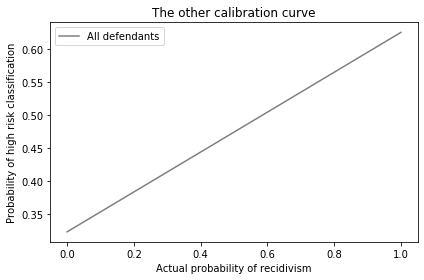

In [9]:
from utils import decorate

cal_all.plot(color='gray', label='All defendants')

decorate(xlabel='Actual probability of recidivism',
         ylabel='Probability of high risk classification',
         title='The other calibration curve')
plt.legend();

In [10]:
white = (cp.race=='Caucasian')
cal_white = prob_highrisk_vs_prob_recid(cp[white])

In [11]:
black = (cp.race=='African-American')
cal_black = prob_highrisk_vs_prob_recid(cp[black])

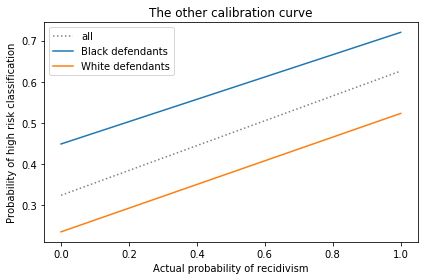

In [12]:
cal_all.plot(linestyle='dotted', color='gray', label='all')
cal_black.plot(label='Black defendants')
cal_white.plot(label='White defendants')

decorate(xlabel='Actual probability of recidivism',
         ylabel='Probability of high risk classification',
         title='The other calibration curve')
plt.legend();

In [13]:
male = (cp['sex'] == 'Male')
cal_male = prob_highrisk_vs_prob_recid(cp[male])

In [14]:
female = (cp['sex'] == 'Female')
cal_female = prob_highrisk_vs_prob_recid(cp[female])

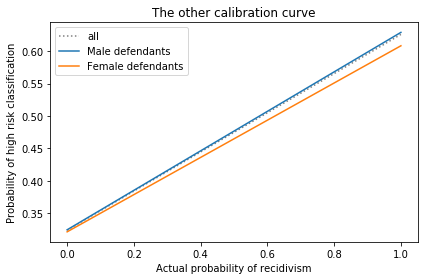

In [15]:
cal_all.plot(linestyle='dotted', color='gray', label='all')
cal_male.plot(label='Male defendants')
cal_female.plot(label='Female defendants')

decorate(xlabel='Actual probability of recidivism',
         ylabel='Probability of high risk classification',
         title='The other calibration curve')
plt.legend();